In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType, StringType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
sc = spark.sparkContext

## Creando una tabla temporal con el dataset de pinguinos

In [4]:
# df = pd.read_csv('data/penguins.csv')
# df.info()

In [5]:
df = spark.read.options(header=True).csv('data/penguins.csv')

In [6]:
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
df.printSchema()

root
 |-- species: string (nullable = true)
 |-- island: string (nullable = true)
 |-- bill_length_mm: string (nullable = true)
 |-- bill_depth_mm: string (nullable = true)
 |-- flipper_length_mm: string (nullable = true)
 |-- body_mass_g: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- year: string (nullable = true)



In [8]:
penguins_schema = StructType([
    StructField('species', StringType(), True),
    StructField('island', StringType(), True),
    StructField('bill_length', FloatType(), True),
    StructField('bill_depth', FloatType(), True),
    StructField('flipper_length_mm', FloatType(), True),
    StructField('body_mass_g', FloatType(), True),
    StructField('sex', StringType(), True),
    StructField('year', StringType(), True)
])

In [9]:
df = spark.read.options(header=True).csv('data/penguins.csv', schema=penguins_schema)

In [10]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length        342 non-null    float32
 3   bill_depth         342 non-null    float32
 4   flipper_length_mm  342 non-null    float32
 5   body_mass_g        342 non-null    float32
 6   sex                344 non-null    object 
 7   year               344 non-null    object 
dtypes: float32(4), object(4)
memory usage: 16.2+ KB


In [11]:
df = df.dropna(how='any')

In [12]:
df.createOrReplaceTempView("penguins")

## Ejecutando consultas SQL sobre el dataframe.

In [13]:
spark.sql(
    """
    SELECT * FROM penguins;
    """
).toPandas()

,species,island,bill_length,bill_depth,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.099998,18.700001,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.500000,17.400000,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.299999,18.000000,195.0,3250.0,female,2007
3,Adelie,Torgersen,36.700001,19.299999,193.0,3450.0,female,2007
4,Adelie,Torgersen,39.299999,20.600000,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
337,Chinstrap,Dream,55.799999,19.799999,207.0,4000.0,male,2009
338,Chinstrap,Dream,43.500000,18.100000,202.0,3400.0,female,2009
339,Chinstrap,Dream,49.599998,18.200001,193.0,3775.0,male,2009
340,Chinstrap,Dream,50.799999,19.000000,210.0,4100.0,male,2009


## ¿Cuantos pinguinos hay cada especie?

In [14]:
species_penguin_count = spark.sql(
    """
    SELECT species, COUNT(*) AS count
    FROM penguins
    GROUP BY species;
    """
).toPandas()

In [15]:
species_penguin_count.head()

,species,count
0,Gentoo,123
1,Adelie,151
2,Chinstrap,68


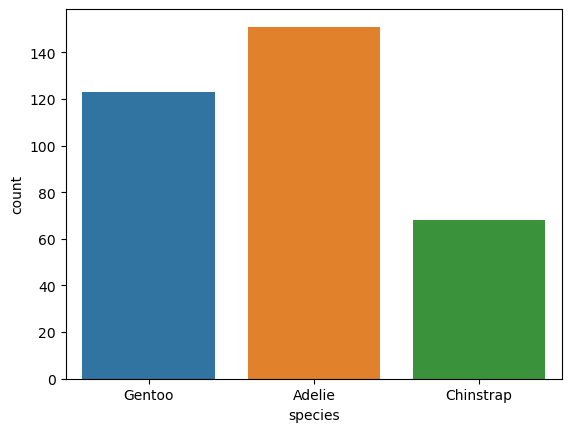

In [16]:
sns.barplot(
    data=species_penguin_count,
    x='species',
    y='count'
)
plt.show()

## ¿Cuantos pinguinos hay por cada sexo?

In [17]:
sex_count = spark.sql(
    """
    SELECT sex, COUNT(*) as count
    FROM penguins
    WHERE sex != 'NA'
    GROUP BY sex;
    
    """
).toPandas()

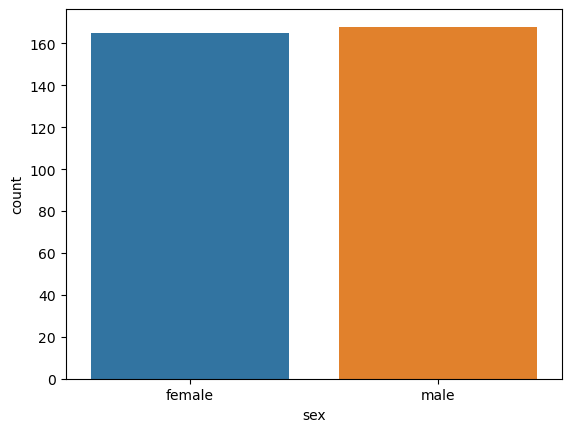

In [18]:
sns.barplot(
    data=sex_count,
    x='sex',
    y='count'
)
plt.show()

In [19]:
species_sex_count = spark.sql(
    """
    SELECT species, sex, COUNT(*) as count
    FROM penguins
    WHERE sex != 'NA' OR sex = 'male'
    GROUP BY 1, 2
    ORDER BY 1;
    """
).toPandas()

In [20]:
species_sex_count

,species,sex,count
0,Adelie,male,73
1,Adelie,female,73
2,Chinstrap,male,34
3,Chinstrap,female,34
4,Gentoo,female,58
5,Gentoo,male,61


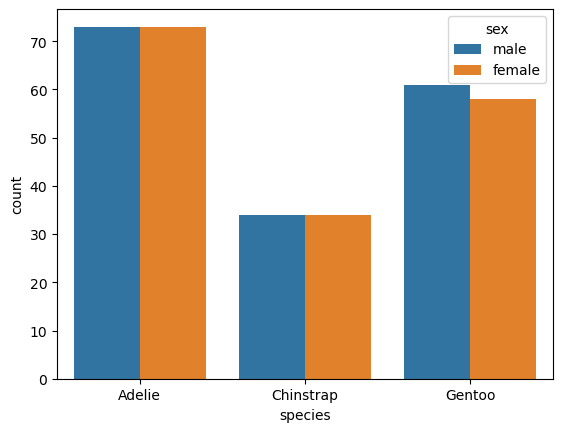

In [21]:
sns.barplot(
    data=species_sex_count,
    x='species',
    y='count',
    hue='sex'
)
plt.show()

In [22]:
spark.sql(
    """
    SELECT species, sex, COUNT(*) as count
    FROM penguins
    WHERE sex = 'male'
    GROUP BY 1, 2;
    """
).show()

+---------+----+-----+
|  species| sex|count|
+---------+----+-----+
|Chinstrap|male|   34|
|   Gentoo|male|   61|
|   Adelie|male|   73|
+---------+----+-----+



In [23]:
spark.sql(
    """
    SELECT species, sex, COUNT(*) as count
    FROM penguins
    WHERE sex = 'female'
    GROUP BY 1, 2;
    """
).show()

+---------+------+-----+
|  species|   sex|count|
+---------+------+-----+
|   Gentoo|female|   58|
|Chinstrap|female|   34|
|   Adelie|female|   73|
+---------+------+-----+



## ¿En promedio cual es largo de las aletas de un pinguino dependiendo a su especie?

In [24]:
flipper_length_average = spark.sql(
    """
    SELECT species, AVG(flipper_length_mm) AS average
    FROM penguins
    GROUP BY species;
    """
).toPandas()
flipper_length_average

,species,average
0,Gentoo,217.186992
1,Adelie,189.953642
2,Chinstrap,195.823529


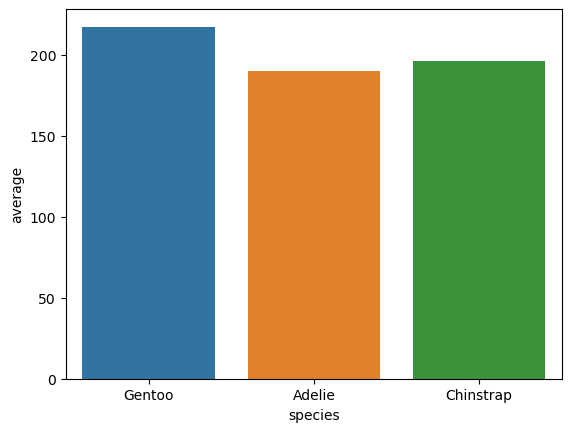

In [25]:
sns.barplot(
    data=flipper_length_average,
    x='species',
    y='average'
)
plt.show()

## ¿Cual es la especie de penguinos en promedio pesa más?

In [26]:
spark.sql(
    """
    SELECT species, (AVG(body_mass_g) / 1000) AS K
    FROM penguins
    GROUP BY species;
    """
).show()

+---------+------------------+
|  species|                 K|
+---------+------------------+
|   Gentoo| 5.076016260162602|
|   Adelie| 3.700662251655629|
|Chinstrap|3.7330882352941175|
+---------+------------------+



## ¿Qué especie de pinguinos tiene el pico más largo?

In [27]:
spark.sql(
    """
    SELECT species, AVG(bill_length)
    FROM penguins
    GROUP BY species;
    """
).show()

+---------+-----------------+
|  species| avg(bill_length)|
+---------+-----------------+
|   Gentoo|47.50487803637497|
|   Adelie|38.79139047584786|
|Chinstrap|48.83382365282844|
+---------+-----------------+



In [29]:
sc.stop()